# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

ValueError: The original URL is broken so the StanfordCars dataset cannot be downloaded anymore.

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


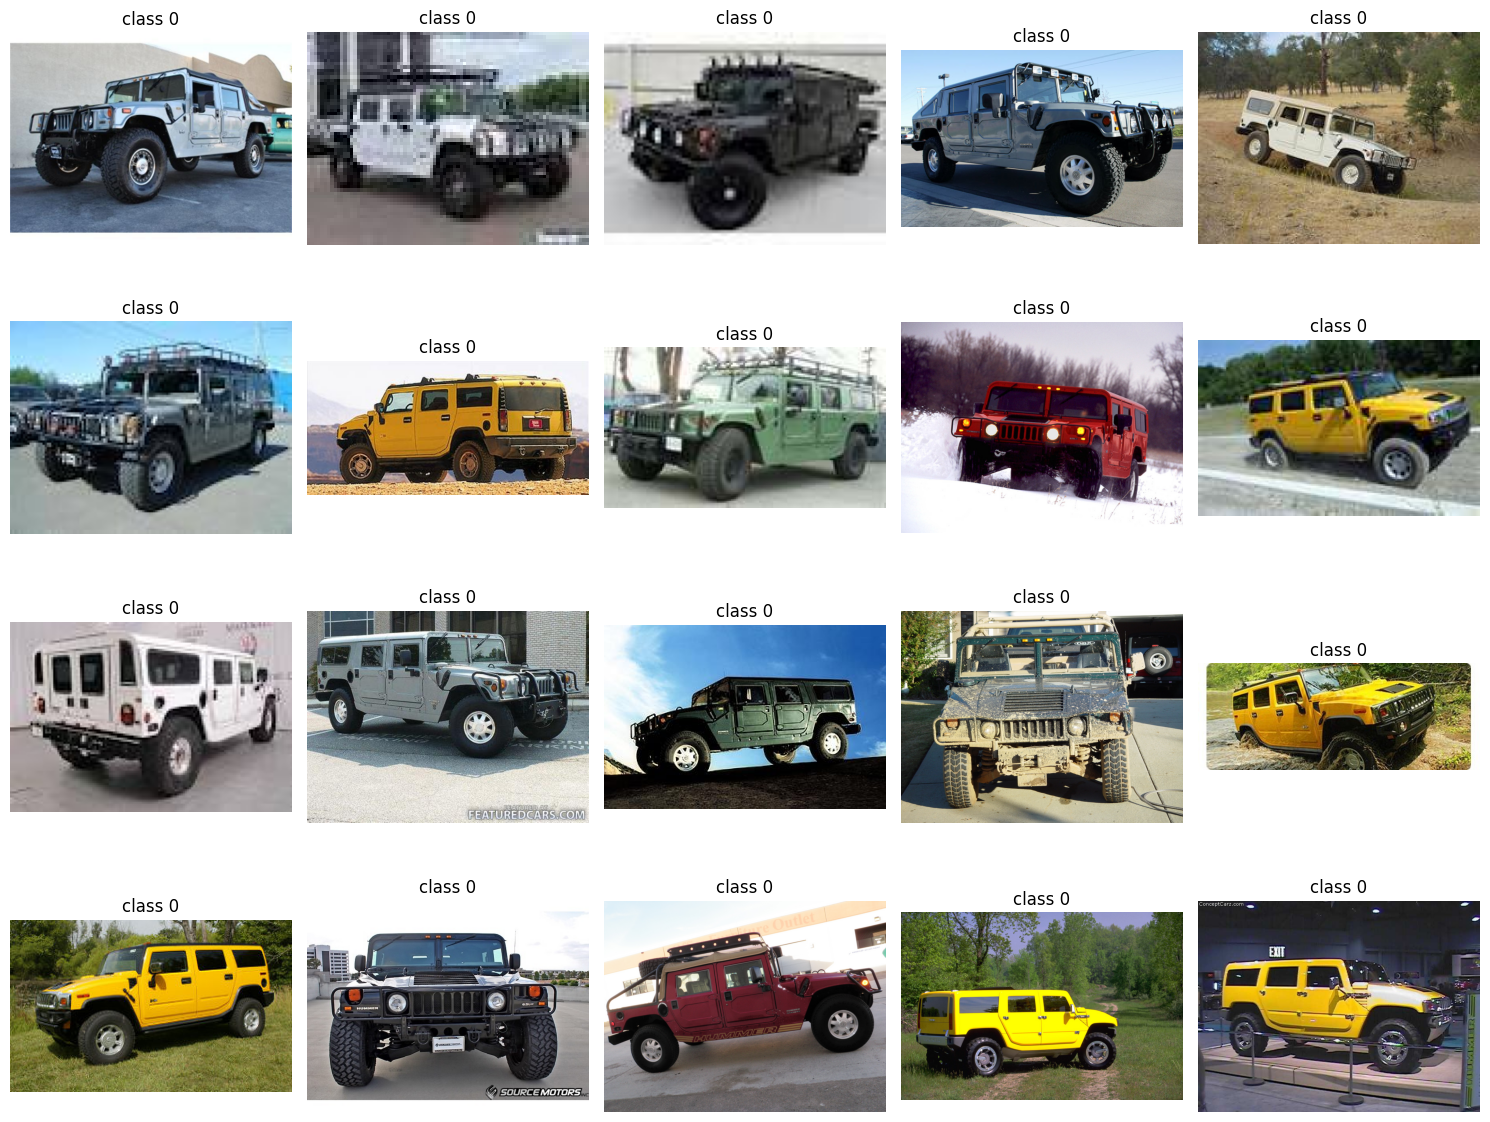

In [1]:
# 예제 1.1 (수정): Hugging Face 기반 Stanford Cars 위 코드가 안돌아가서 수정
!pip install -q datasets torch torchvision matplotlib

from datasets import load_dataset
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt


def ensure_rgb(example):
    img = example["image"]
    if img.mode != "RGB":
        img = img.convert("RGB")
    # 크기도 통일 (예: 64×64)
    img = img.resize((64, 64))
    example["image"] = img
    return example

# 로드 + 변환 (dataset.map 사용)
dataset = load_dataset("tanganke/stanford_cars")
dataset = dataset.map(ensure_rgb)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])


# --- HF Dataset → PyTorch Dataset ---
class StanfordCarsHF(Dataset):
    """
    Hugging Face 'tanganke/stanford_cars'를 PyTorch처럼 쓰기 위한 래퍼
    - 반환: (PIL.Image 또는 Tensor, int label)
    """
    def __init__(self, split="train", transform=None):
        self.ds = load_dataset("tanganke/stanford_cars", split=split)
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"]

        if img.mode != "RGB":
            img = img.convert("RGB")

        label = int(item["label"])

        if self.transform:
            img = self.transform(img)

        if isinstance(img, torch.Tensor) and img.ndim == 3 and img.shape[0] == 1:
          img = img.repeat(3, 1, 1)

        return img, label

# --- 시각화 ---
def show_images(dataset, num_samples=20, cols=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        img, label = dataset[i]
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).numpy()
        plt.subplot(int(np.ceil(num_samples / cols)), cols, i + 1)
        plt.imshow(np.array(img))
        plt.title(f"class {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- 사용 예시 ---
train_data = StanfordCarsHF(split="train")
show_images(train_data, num_samples=20, cols=5)



`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'tanganke/stanford_cars' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'tanganke/stanford_cars' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be ab

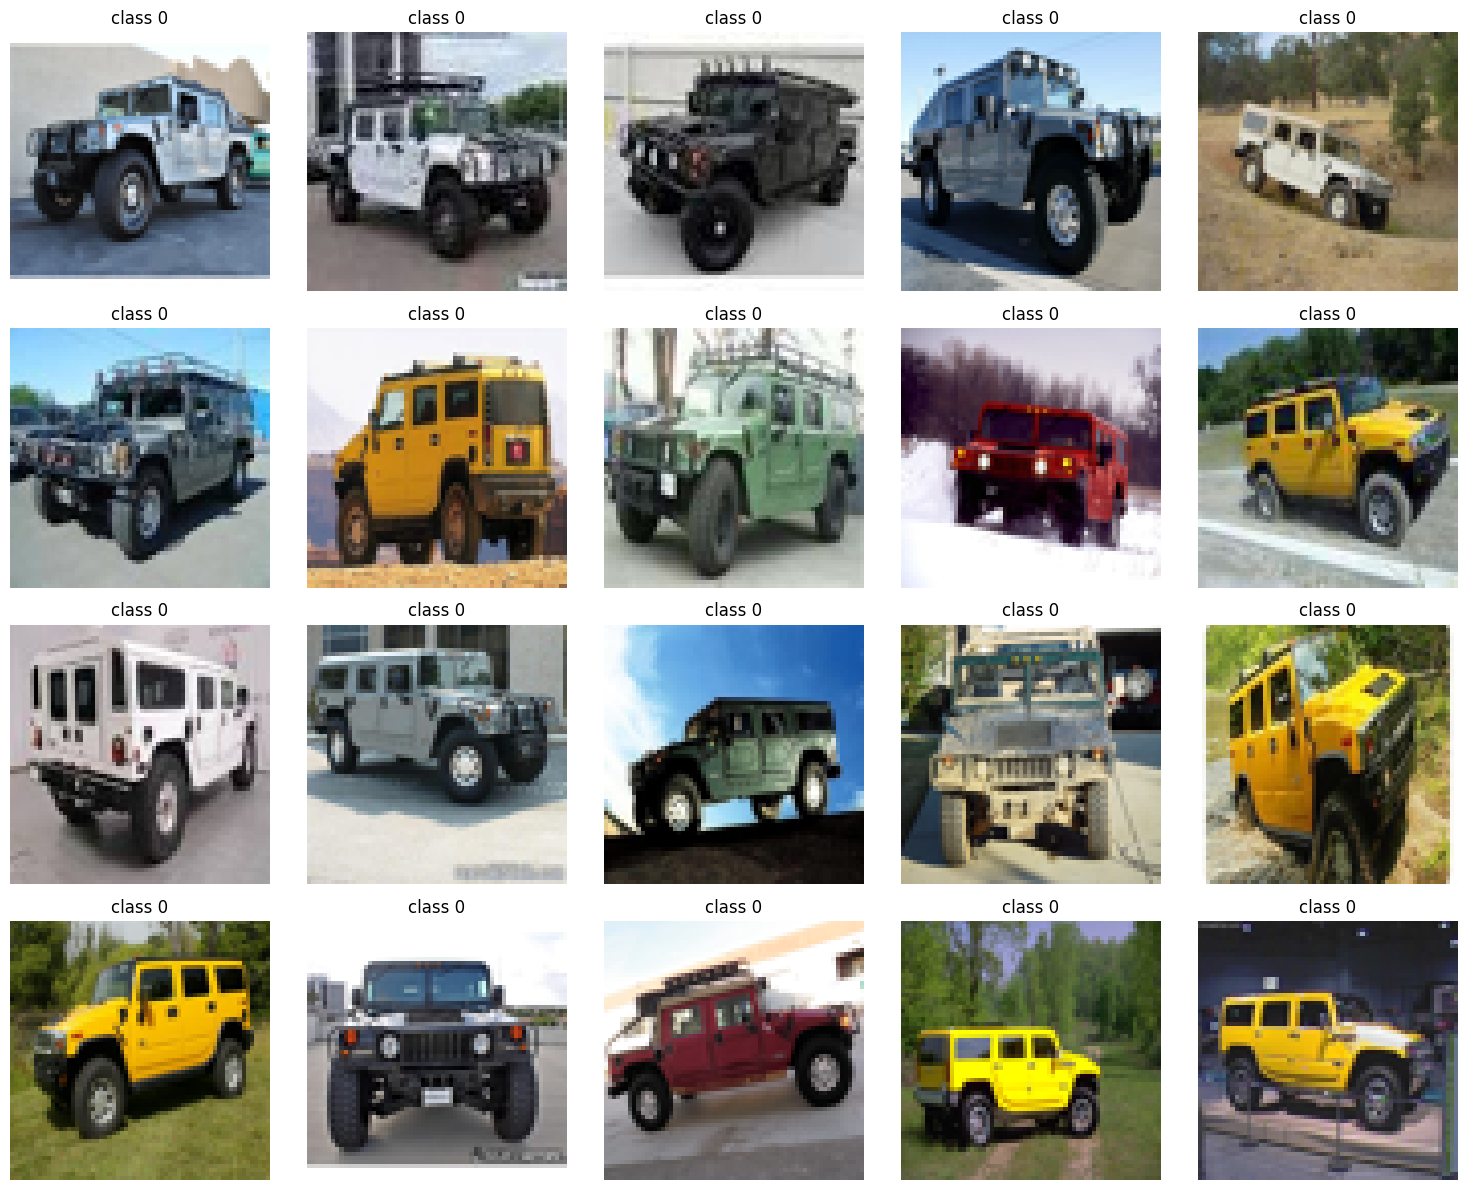

In [1]:
# 예제 1.1 (최종) — Hugging Face + map 전처리 → PyTorch 래퍼 (채널/크기 통일, 재다운로드 없음)
!pip install -q datasets torch torchvision matplotlib

from datasets import load_dataset
from torchvision import transforms            # ✅ 빠졌던 임포트
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch, numpy as np, matplotlib.pyplot as plt

# 1) 전처리: PIL 단계에서 RGB 통일 + 64x64 리사이즈
def ensure_rgb(example):
    img = example["image"]
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((64, 64))
    example["image"] = img
    return example

# 2) 한 번만 로드 & 전처리 (여기서 만든 dataset만 사용!)
dataset = load_dataset("tanganke/stanford_cars", trust_remote_code=True)
dataset = dataset.map(ensure_rgb)

# 3) 학습/시각화용 변환
to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),                     # [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)   # [-1,1]
])

# 4) HF → PyTorch 래퍼 (전처리된 dataset을 주입!)
class StanfordCarsHF(Dataset):
    """
    전처리(map)済 Hugging Face dataset을 PyTorch처럼 사용하는 래퍼
    - 반환: (Tensor[C,H,W], int label)
    """
    def __init__(self, base_ds, split="train", transform=None):
        self.ds = base_ds[split]               # ✅ 재-로드 금지, 주입된 데이터만 사용
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"]                    # PIL.Image (이미 RGB, 64x64)
        label = int(item["label"])
        if self.transform:
            img = self.transform(img)          # → Tensor
        # 혹시라도 1채널이 남아있으면 방어 (이론상 여기선 발생 X)
        if isinstance(img, torch.Tensor) and img.ndim == 3 and img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        return img, label

# 5) 시각화 유틸
def show_images(ds, num_samples=20, cols=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        img, label = ds[i]
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).numpy()
            img = ((img + 1) / 2).clip(0,1)    # [-1,1] → [0,1] 복원(변환 썼을 때 대비)
        plt.subplot(int(np.ceil(num_samples/cols)), cols, i+1)
        plt.imshow(np.array(img))
        plt.title(f"class {label}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

# 6) 사용 예시
train_data = StanfordCarsHF(dataset, split="train", transform=to_tensor_norm)  # ✅ 주입
show_images(train_data, num_samples=20, cols=5)

# (원하면 DataLoader)
# dataloader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)


# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  #베타 값을 선형적으로 증가시키는 schedule
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form (미리 계산되는 항목들)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [3]:
!pip install -q datasets torchvision

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt

IMG_SIZE = 64
BATCH_SIZE = 128

# --- Hugging Face용 Dataset 래퍼 ---
class StanfordCarsHF(Dataset):
    def __init__(self, split="train", transform=None):
        self.ds = load_dataset("tanganke/stanford_cars", split=split)
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx): #주어진 인덱스의 데이터(이미지, 라벨) 반환
        item = self.ds[idx]
        img = item["image"]
        label = int(item["label"])
        if self.transform:
            img = self.transform(img)
        return img, label

#데이터 변환 정의
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = StanfordCarsHF(split="train", transform=data_transform)
    test = StanfordCarsHF(split="test", transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test]) #test 와 train 을 하나로 합쳐 반환

#이미지 복원 및 시각화
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch 배치 이미지일 경우 첫 번째 이미지만 시각화
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


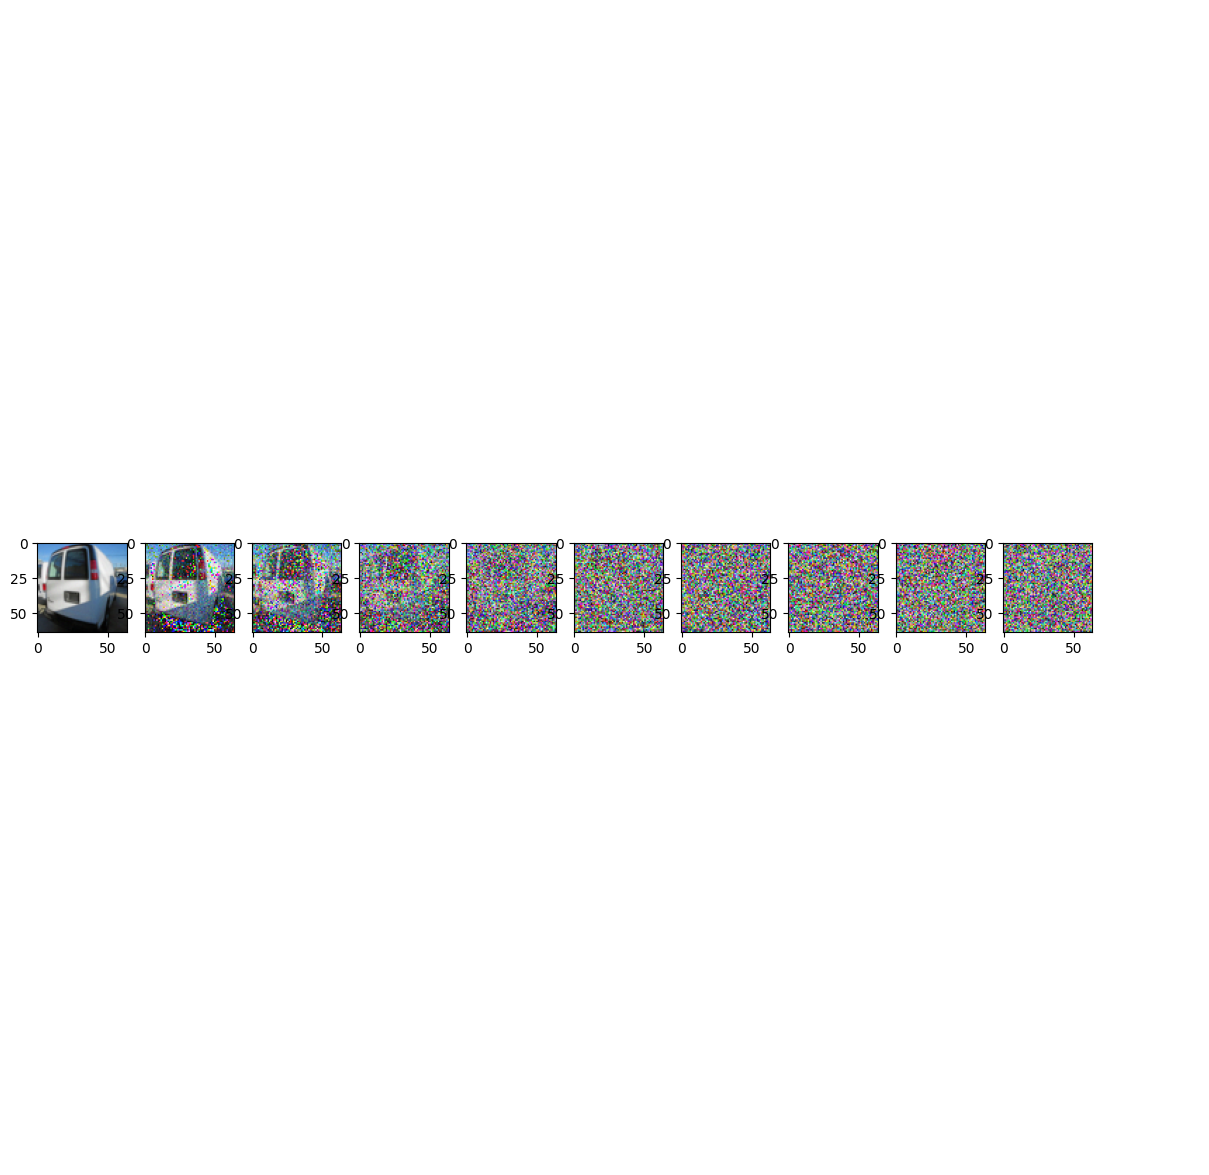

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off') #축 숨기기:
num_images = 10
stepsize = int(T/num_images)

#여러 timestamp 에서 노이즈가 점점 추가되는 과정 시각화
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [5]:
from torch import nn
import math


#U-Net 의 기본 블록
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) #시간 임베딩을 채널 차원에 맞게 변환
        if up:
            #skip connection 과 concat 되므로 입력 채널 2배
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            #다운샘플링
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :] #시점 t 를 주파수 벡터에 곱함
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here: sin > cos 순서로 오는 게 맞음
        return embeddings #최종 시간 임베딩 벡터


#SimpleUnet 정의
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    #시점 t 에 맞는 파라미터 값 추출
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    #사후 분산 (posterior variance) 계산
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment) 마지막 스텝인 경우 더 이상 노이즈를 추가하지 않고 결과 반환
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        # 그 외에서는 랜덤 노이즈 추가하여 샘플링 지속
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      #무작위 시점 t 생성 (0~T 사이의 정수)
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #현재 배치(batch[0] = 이미지) 와 시점 t 로 손실 계산
      loss = get_loss(model, batch[0], t)
      #역전파 및 가중치 업데이트
      loss.backward()
      optimizer.step()

      #5에폭마다 첫 스텝에서 학습 상태 출력 및 샘플 시각화
      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()